<a href="https://colab.research.google.com/github/chengyang122/Metter.js-and-MediaPipe-Interactive-game/blob/main/OriginalZBarDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To use this you need to change the address of picture to picture in your google drive or upload then on the file system left side.

In [1]:
import cv2
import numpy as np
from skimage.morphology import octagon
from scipy.signal import medfilt2d
from skimage.filters.rank import tophat, bottomhat
from tensorflow.keras.preprocessing import image
from skimage import measure
from skimage.measure import regionprops
from skimage.measure import regionprops_table
from scipy.stats import norm
import warnings
import matplotlib.pyplot as plt
from scipy.ndimage import binary_opening
warnings.filterwarnings('ignore')
import os
from google.colab.patches import cv2_imshow
from skimage import morphology
import pandas as pd
from skimage import io, morphology
import matplotlib.pyplot as plt
from PIL import Image as im
import matplotlib.pyplot as plt
import skimage
from skimage.io import imread, imshow
from skimage.color import rgb2gray, rgb2hsv
from skimage.measure import label, regionprops, regionprops_table
from skimage.filters import threshold_otsu
from scipy.ndimage import median_filter
from matplotlib.patches import Rectangle
from tqdm import tqdm
from PIL import Image as im
%matplotlib inline


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Igray_matlab = pd.read_csv('/content/Igray.csv', header=None).to_numpy()
# closeimg_matlab = pd.read_csv('/content/close.csv', header=None).to_numpy()
# openclose_matlab = pd.read_csv('/content/openclose.csv', header=None).to_numpy()
# tophatimg_matlab = pd.read_csv('/content/tophatimg.csv', header=None).to_numpy()
# bothatimg_matlab = pd.read_csv('/content/bothatimg.csv', header=None).to_numpy()
# BW3_matlab = pd.read_csv('/content/BW3.csv', header=None).to_numpy()

In [ ]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2990 * b + 0.5870 * g + 0.1140 * r
    return gray

In [ ]:
def matlab_disk(radius):
  new_radius = radius - 1
  y,x = np.ogrid[-new_radius: new_radius+1, -new_radius: new_radius+1]
  mask = x**2+y**2<radius**2
  return mask.astype(int)

In [ ]:
def show_area(regCo, theimage):
  fig, ax = plt.subplots(1,1)
  ax.imshow(theimage[int(regCo[0]):int(regCo[2]), int(regCo[1]):int(regCo[3])])


In [ ]:
def imoverlay(newImage, mask):
  newImage[mask>0]=255
  return newImage

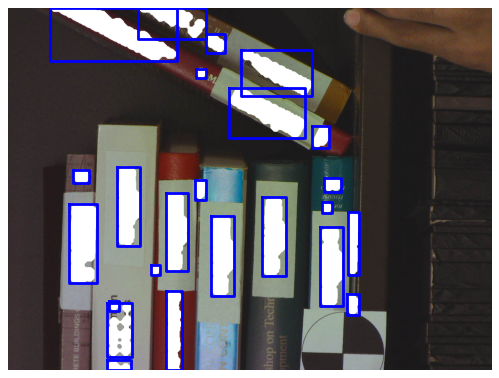

In [ ]:
imfilname1 = '/content/drive/MyDrive/barcode/capture_2018_08_08_05_30_52.png'
imCamA  = cv2.imread(imfilname1)
SE_Radius = [(3, 2), (5, 4), (7, 6), (9, 8), (11, 10)]
delsig = 0.0
seTopBotHat = octagon(7, 6)
seDilate = np.array(matlab_disk(5), dtype = np.uint8)#are different
seClose  = np.array(matlab_disk(5), dtype = np.uint8)#are different
seOpenLast = np.array(matlab_disk(5), dtype = np.uint8)#are different
IgrayArray  = np.zeros((3,1))
rgbArray    = np.zeros((3,1))
fileNames = [imCamA, imCamA, imCamA]
[rows, cols, colordepth] = fileNames[0].shape
multiscaleResponseimgold = np.zeros((rows,cols))
IgrayArray = []
imgCnt = 1
imUndistored = fileNames[0]
gray = rgb2gray(imUndistored)
Igray  = medfilt2d(gray,[5,5])
Igray = np.rint(Igray)
#Igray_norm = cv2.normalize(Igray, None, alpha=0, beta=1,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
#tophatimg = tophat(Igray_norm, seTopBotHat)
tophatimg = cv2.morphologyEx(Igray, cv2.MORPH_TOPHAT,seTopBotHat)
#bothatimg = bottomhat(Igray_norm, seTopBotHat)
bothatimg = cv2.morphologyEx(Igray, cv2.MORPH_BLACKHAT,seTopBotHat)
enhanceimg = tophatimg+bothatimg
dilateimg = cv2.dilate(enhanceimg,seDilate)
closeimg  = cv2.morphologyEx(dilateimg,cv2.MORPH_CLOSE,seClose)
for i in range(len(SE_Radius)-1):
  seOpen1   = octagon(*SE_Radius[i])
  seOpen2   = octagon(*SE_Radius[i+1])
  IMopen_new1 = cv2.morphologyEx(closeimg, cv2.MORPH_OPEN, seOpen1)
  IMopen_new2 = cv2.morphologyEx(closeimg, cv2.MORPH_OPEN, seOpen2)
  multiscaleResponseimgnew = np.maximum(IMopen_new1, IMopen_new2)
  multiscaleResponseimgold = np.maximum(multiscaleResponseimgold,multiscaleResponseimgnew)
openCloseimg   = cv2.morphologyEx(cv2.morphologyEx(multiscaleResponseimgnew,cv2.MORPH_OPEN,seOpenLast),cv2.MORPH_CLOSE,seOpenLast)
#openCloseimg = openclose_matlab
#level, _ = cv2.threshold(openCloseimg,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#_, BW = cv2.threshold(openCloseimg, 128, 255, cv2.THRESH_BINARY)
openCloseimg = image.img_to_array(openCloseimg, dtype='uint8')
level, BW = cv2.threshold(openCloseimg,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
CC2 = measure.label(BW)
#CC2 = openCloseimg
S2 = regionprops(CC2)
area = [prop.area for prop in S2]
mu_morph = np.mean(area)
sigma_morph = np.std(area)**2
cleaned = morphology.remove_small_objects(CC2, min_size=0, connectivity= 8)# weird preformance 
#rgb = cv2.addWeighted(Igray.astype(int),0.2,cleaned.astype(int),100,0) #need more test rgb = imoverlay(Igray, BW3, [1 0 0]); 
st = regionprops(cleaned)
properties =['area','bbox','convex_area','bbox_area',
             'major_axis_length', 'minor_axis_length',
             'eccentricity']
df = pd.DataFrame(regionprops_table(cleaned, properties = properties))
blob_coordinates = [(row['bbox-0'],row['bbox-1'],
                     row['bbox-2'],row['bbox-3']) for 
                    index, row in df.iterrows()]
fig, ax = plt.subplots(1,1, figsize=(8, 6), dpi = 80)
rgb_imCamA = cv2.cvtColor(imCamA, cv2.COLOR_BGR2RGB)
masked_imCamA = imoverlay(rgb_imCamA, cleaned)
for box in blob_coordinates:
    x = (box[1], box[3], box[3], box[1], box[1])
    y = (box[0], box[0], box[2], box[2], box[0])
    ax.plot(x, y, '-b', linewidth=2.5)
ax.imshow(masked_imCamA);
ax.set_axis_off()
